# **1. Configuración del ambiente**

In [1]:
import pandas as pd
import numpy as np
import requests
import yfinance as yf
from bs4 import BeautifulSoup
# from datetime import date, timedelta

In [2]:
global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision

# **2. Obtención de los datos**

## **2.1 Precios Historicos del Bitcoin**

In [3]:
def importar_base_bitcoin():
  global df_bitcoin
  #Obteniendo datos historicos del Bitcoin
  df_bitcoin = yf.download('BTC-USD', period= '7d', interval='5m')

In [4]:
importar_base_bitcoin()
df_bitcoin.head(5)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2024-03-20 00:00:00+00:00,61930.351562,62163.566406,61930.351562,62094.578125,62094.578125,0
2024-03-20 00:05:00+00:00,61917.066406,62120.085938,61917.066406,62102.578125,62102.578125,108412928
2024-03-20 00:10:00+00:00,62130.250000,62168.722656,62033.789062,62033.789062,62033.789062,165732352
2024-03-20 00:15:00+00:00,62098.375000,62439.648438,61970.316406,62439.648438,62439.648438,0
2024-03-20 00:20:00+00:00,62511.628906,62653.246094,62511.355469,62653.246094,62653.246094,385015808


## **2.2 Extrayendo precio actual y tendencia del Bitcoin.**

In [5]:
def extraer_tendencias():
  global precio_actual, tendencia
  url = 'https://coinmarketcap.com/'
  respuesta = requests.get(url)

  #Verificando que la busquedad fue un exito
  if respuesta.status_code == 200:
    s = BeautifulSoup(respuesta.content, 'lxml')

    #Obteniendo los span de la primera fila de la tabla de coinmarketcap.com
    html_row = s.findAll("tr")
    html_row = html_row[1]
    elementos = html_row.findAll("span")

    #Obteniendo el precio actual del Bitcoin en USD
    precio_actual = float(elementos[2].text.replace('$', '').replace(',',''))

    #Obteniendo  la tendencia
    if elementos[3].next.attrs['class'][0] == "icon-Caret-up":
      tendencia = 'Alta'
    else:
      tendencia = 'Baja'

  else:
    print("Error al cargar la página de CoinMarketCap")

In [6]:
extraer_tendencias()
print(f'Precio Actual: ${precio_actual} USD')
print(f'Tendencia: {tendencia}')

Precio Actual: $70551.3 USD
Tendencia: Alta


# **3. Limpieza de datos**

## **3.1 Análisis antes de la limpieza de datos**

In [55]:
# Creando copia del dataframe bitcoin
global df_bitcoin_limpio
df_bitcoin.drop('Adj Close', axis =1, inplace=True)
df_bitcoin_limpio = df_bitcoin.copy()

In [56]:
def analisis():
  global df_bitcoin_limpio
  indices_repetidos = df_bitcoin_limpio.duplicated().sum()
  valores_nulos_close = 'Si' if df_bitcoin_limpio.Close.isna().any() == True else "No"
  registros_cero = df_bitcoin_limpio.Volume[df_bitcoin_limpio.Volume <= 0].count()

  print(f'Existen {indices_repetidos} indices repetidos.')
  print(f'Existen valores nulos en la columna "Close": {valores_nulos_close}')
  print(f'Registros que tengan registros Volume de transacción menor o igual a cero: {registros_cero}')
analisis()

Existen 0 indices repetidos
Existen valores nulos en la columna "Close": No
Registros que tengan registros Volume de transacción menor o igual a cero: 1033


In [57]:
df_bitcoin_limpio.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1807 entries, 2024-03-20 00:00:00+00:00 to 2024-03-26 06:30:00+00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1807 non-null   float64
 1   High    1807 non-null   float64
 2   Low     1807 non-null   float64
 3   Close   1807 non-null   float64
 4   Volume  1807 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 84.7 KB


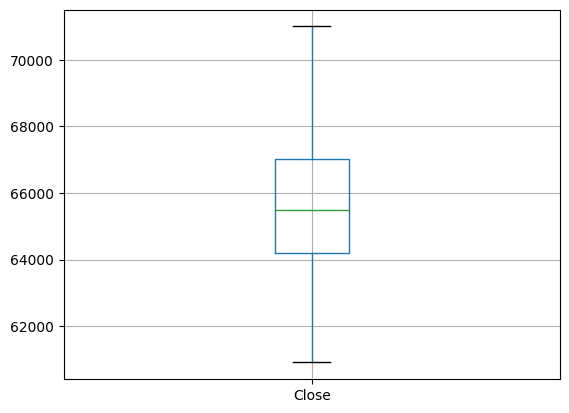

In [59]:
df_bitcoin_limpio.boxplot('Close');

## **3.2 Creación de la función que limpia la base de datos**

In [65]:
def limpieza_datos():
  global df_bitcoin, media_bitcoin, df_bitcoin_limpio
  #Creando una copia del dataframe original
  df_bitcoin_limpio = df_bitcoin.copy()

  # Eliminando valores respetidos del dataframe en caso de existir
  df_bitcoin_limpio.drop_duplicates(inplace=True)

  # Tratando los valores nulos de la columna close
  valores_nulos = df_bitcoin.Close.isna().any()
  if valores_nulos == True:
    df_bitcoin_limpio.Close.fillna(method='ffill', inplace=True)

  # Eliminado registros que tengan un Volume de transaccion igual cero
  query = df_bitcoin_limpio.query('Volume <= 0').index
  df_bitcoin_limpio.drop(query, axis = 0, inplace = True)

  # Seleccionado registro de la columna Close que esten entre Q1 y Q3
  Q1 = df_bitcoin_limpio.Close.quantile(0.25)
  Q3 = df_bitcoin_limpio.Close.quantile(0.75)
  # IIQ = Q3-Q1
  df_bitcoin_limpio = df_bitcoin_limpio.query(f'Close > {Q1} & Close < {Q3}')

  # Calculando la media con los datos ya filtrados.
  media_bitcoin = df_bitcoin_limpio.Close.mean()
  df_bitcoin

limpieza_datos()

In [69]:
analisis()

Existen 0 indices repetidos
Existen valores nulos en la columna "Close": No
Registros que tengan registros Volume de transacción menor o igual a cero: 0
